In [5]:
#!pip install adversarial-robustness-toolbox

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score
from sklearn.linear_model import LogisticRegression

In [8]:
#Implementation of logistic Regression
from LogisticRegression import LogisticRegression

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
df=pd.read_csv('../data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# DATA PRE PROCESSING

**One hot encoding**

In [11]:
# categorical columns
cp = pd.get_dummies(df['cp'],prefix= 'cp')
thal = pd.get_dummies(df['thal'],prefix = 'thal')
slope = pd.get_dummies(df['slope'],prefix = 'slope')

#merge dummy variables to main data frame
frames = [ df,cp,thal,slope]
df = pd.concat(frames,axis=1)

#Dropping the unnecessory variables
df=df.drop(columns = ['cp','thal','slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,0,1,0,0,1,0


**Separating Target Variable**

In [12]:
#Declaring Dependent and Independent variables
X = df.drop(['target'],axis=1)
y = df['target']

**Data Normalization**

In [13]:
X = MinMaxScaler().fit_transform(X)

**Splitting Training and Testing Dataset**

In [14]:
#Splitting x and y into training and testing datasets

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=4)

In [15]:
#checking the shape of X_train and X_test
X_train.shape, X_test.shape

((820, 21), (205, 21))

# Training Model

In [16]:
model = LogisticRegression(learning_rate=0.1, num_iterations=300000)

In [17]:
%%time
model.fit(X_train, y_train)  # about 3min

CPU times: total: 15min 4s
Wall time: 2min 57s


# Predictions

In [18]:
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84       107
           1       0.78      0.94      0.85        98

    accuracy                           0.84       205
   macro avg       0.86      0.85      0.84       205
weighted avg       0.86      0.84      0.84       205



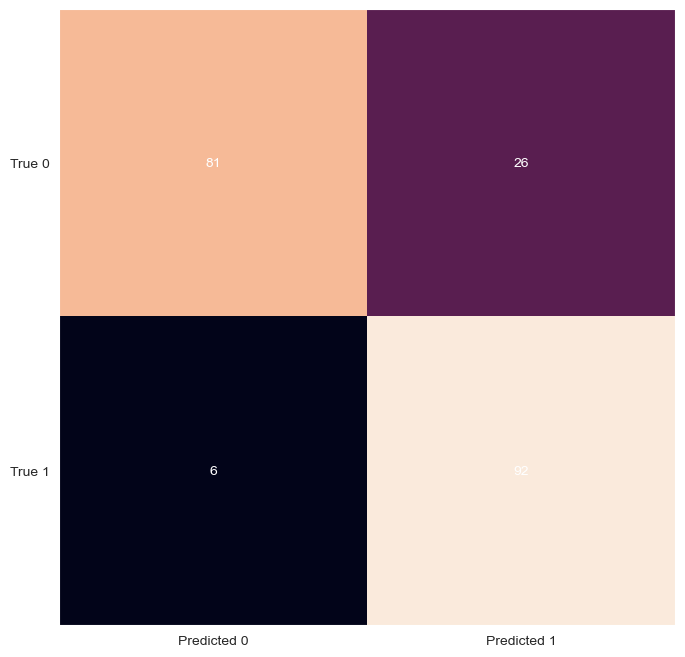

In [20]:
cm = confusion_matrix(y_test, preds)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('True 0', 'True 1'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()